**Importing necessary libraries**

In [ ]:
import pandas as pd
import random
import gym
import numpy as np
import matplotlib.pyplot as plt

<b>File upload</b>

In [ ]:
# We are using Google colab import option
from google.colab import files
uploaded = files.upload()
data_set = pd.read_csv("cancer.csv")

Saving cancer.csv to cancer (1).csv


In [ ]:
data_set.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,Treatment Type,"Treatment status(0=Failure,1=Success)",budget(in dollars),Time(In days)
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,Chemotherapy,1,16442,224
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,Surgery,1,40967,324
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,Surgery,0,18947,334
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,Radiation Therapy,1,48807,102
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,Surgery,0,36349,183


In [ ]:
# Creating necessary datapoints to capture treatment success rate, related budget and day requirement
df2 = data_set
df3 = pd.pivot_table(
   df2,
   index=['diagnosis','Treatment Type'],
   aggfunc={'Treatment status(0=Failure,1=Success)': np.sum, 'diagnosis':len,'budget(in dollars)':np.sum, 'Time(In days)':np.sum }
).rename(columns={'diagnosis': 'Total number of trials'})
df3["Success rate"] = df3["Treatment status(0=Failure,1=Success)"]/df3["Total number of trials"]
df3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Time(In days)  \
diagnosis Treatment Type                     
B         Chemotherapy                2894   
          Harmone Therapy             4041   
          Radiation Therapy          56425   
          Surgery                    15299   
M         Chemotherapy               19019   
          Radiation Therapy           7246   
          Surgery                    20456   

                             Treatment status(0=Failure,1=Success)  \
diagnosis Treatment Type                                             
B         Chemotherapy                                           8   
          Harmone Therapy                                       12   
          Radiation Therapy                                    128   
          Surgery                                               39   
M         Chemotherapy                                          47   
          Radiation Therapy                                     14   
          Surgery                                               48   

                             budget(in dollars)  Total number of trials  \
diagnosis Treatment Type                                                  
B         Chemotherapy                   416716                      13   
          Harmone Therapy                509466                      17   
          Radiation Therapy             7820715                     258   
          Surgery                       2002432                      69   
M         Chemotherapy                  2622095                      90   
          Radiation Therapy              962499                      32   
          Surgery                       2833230                      90   

                             Success rate  
diagnosis Treatment Type                   
B         Chemotherapy           0.615385  
          Harmone Therapy        0.705882  
          Radiation Therapy      0.496124  
          Surgery                0.565217  
M         Chemotherapy           0.522222  
          Radiation Therapy      0.437500  
          Surgery                0.533333

<b><h4>Bandits</h4></b>
*   The different treatment arms are the "Bandits" for this implemenation of MAB algorithm
*   We have suffixed the diagnosis type to treatment arm names as we wanted to retain this differentiation throughout the algorithm and iterations



In [ ]:
data_treatment_list = []
bandits = df3['Success rate']
bandits = bandits.reset_index()['Success rate'].tolist()

for i in range(len(df3)):
  data_treatment_list.append(df3.index[i][0] + '-' + df3.index[i][1])

print(f"data_treatment_list: {data_treatment_list}\n")

print(f"bandits = {bandits}\n")

data_treatment_list: ['B-Chemotherapy', 'B-Harmone Therapy', 'B-Radiation Therapy', 'B-Surgery', 'M-Chemotherapy', 'M-Radiation Therapy', 'M-Surgery']

bandits = [0.6153846153846154, 0.7058823529411765, 0.49612403100775193, 0.5652173913043478, 0.5222222222222223, 0.4375, 0.5333333333333333]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class MultiArmedBanditGymEnv(gym.Env):

  # init method receives bandit winning probabilities
  def __init__(self, bandits):
    self.bandits = bandits
    self.state = {}
    self.reset()

  # After each action environment returns 1$ or -1$ to an agent
  def step(self, action):
    p = self.bandits[action]
    # print(f"===Value of p: {p}===")
    r = random.random()
    # print(f"===Value of r: {r}===")
    reward = 1 if r <= p else -1
    self.state[action].append(reward)
    done = False
    debug = None
    return self.state, reward, done, debug

  def reset(self):
    self.state = {}
    for i in range(len(self.bandits)):
      self.state[i] = []
    return self.state

  #  render method shows the overall statistics of all rounds
  def render(self, mode = "ascii"):
    returns = {}
    trials = {}
    for i in range(len(self.bandits)):
      returns[i] = sum(self.state[i])
      trials[i] = len(self.state[i])
    print(f'=====Total Trials: {sum(trials.values())}=====')
    for b, r in returns.items():
      t = trials[b]
      print(f'Bandit {b}| returns: {r}, trials: {t}')
    print(f'=====Total Returns: {sum(returns.values())}=====')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Model that emulates treatment effectiveness
# Matching list B-Chemotherapy, B-Harmone Therapy, B-Radiation Therapy, B-Surgery, M-Chemotherapy,M-Radiation Therapy, M-Surgery
def get_bandit_env_7():
  # Adding computed success rates from the above pivot table
  # bandits = [0.615385, 0.705882, 0.496124, 0.565217, 0.522222,0.437500,0.533333]
  return MultiArmedBanditGymEnv(bandits)

In [ ]:
# Initialize hyperparameters
epsilon = 0.9  # Starting exploration rate
lambda_success = 0.75 # 0.5
lambda_duration = 0.25
lambda_budget = 0.25
alpha_duration = 0.01
alpha_budget = 0.01

# Specify the number of iterations you want to run
iterations = 1000

# Initialize treatment arms based on unique values in 'Treatment Type'
treatment_types = data_treatment_list
treatment_arms = {treatment: {'trials': 0, 'successes': 0, 'total_cost': 0, 'composite_reward': 0} for treatment in treatment_types}

print("Initialized Treatment Arms:", treatment_arms)


Initialized Treatment Arms: {'B-Chemotherapy': {'trials': 0, 'successes': 0, 'total_cost': 0, 'composite_reward': 0}, 'B-Harmone Therapy': {'trials': 0, 'successes': 0, 'total_cost': 0, 'composite_reward': 0}, 'B-Radiation Therapy': {'trials': 0, 'successes': 0, 'total_cost': 0, 'composite_reward': 0}, 'B-Surgery': {'trials': 0, 'successes': 0, 'total_cost': 0, 'composite_reward': 0}, 'M-Chemotherapy': {'trials': 0, 'successes': 0, 'total_cost': 0, 'composite_reward': 0}, 'M-Radiation Therapy': {'trials': 0, 'successes': 0, 'total_cost': 0, 'composite_reward': 0}, 'M-Surgery': {'trials': 0, 'successes': 0, 'total_cost': 0, 'composite_reward': 0}}


In [ ]:
def calculate_composite_reward(success, duration, cost, lambda_success, lambda_duration, lambda_budget, alpha_duration, alpha_budget):
    R_success = success  # 1 for success, 0 for failure
    R_duration = np.exp(-alpha_duration * duration)
    R_budget = np.exp(-alpha_budget * np.log(cost + 1))
    composite_reward = (lambda_success * R_success +
                        lambda_duration * R_duration +
                        lambda_budget * R_budget)
    return composite_reward

def select_treatment_arm(epsilon, treatment_arms):
    if random.random() < epsilon:
        # Exploration: Select a random trial
        return random.choice(list(treatment_arms.keys()))
    else:
        # Exploitation: Select the arm with the highest composite reward
        max_reward = max(arm['composite_reward'] for arm in treatment_arms.values())
        best_arms = [arm for arm in treatment_arms if treatment_arms[arm]['composite_reward'] == max_reward]
        return random.choice(best_arms)

def update_treatment_arm(arm_name, success, duration, cost, treatment_arms, lambda_success, lambda_duration, lambda_budget, alpha_duration, alpha_budget):
    arm = treatment_arms[arm_name]
    arm['trials'] += 1
    arm['successes'] += success
    arm['total_cost'] += cost
    avg_cost = arm['total_cost'] / arm['trials']
    arm['composite_reward'] = calculate_composite_reward(success, duration, avg_cost,
                                                         lambda_success, lambda_duration, lambda_budget,
                                                         alpha_duration, alpha_budget)

In [ ]:
def arm_number(arm_name):
  for index in range(len(treatment_types)):
      if treatment_types[index] == arm_name:
          return index
  return 0

In [ ]:
def run_epsilon_greedy_iterations(env, df, treatment_arms, epsilon, iterations, lambda_success, lambda_duration, lambda_budget, alpha_duration, alpha_budget):
    state = env.reset()
    print(f"---State: {state}---")
    rewards = []

    for _ in range(iterations):
        # Select a trial based on epsilon-greedy policy
        selected_arm = select_treatment_arm(epsilon, treatment_arms)

        selected_arm_number = arm_number(selected_arm)
        print(f"===Best Bandit: {selected_arm}, Arm Number: {selected_arm_number}===")

        # Randomly select a trial from the dataframe that matches the selected treatment arm
        relevant_trials = df[df['diagnosis'] + '-' + df['Treatment Type'] == selected_arm]
        if not relevant_trials.empty:
            trial = relevant_trials.sample(n=1).iloc[0]
            success = trial['Treatment status(0=Failure,1=Success)']
            duration = trial['Time(In days)']  # Assuming this column exists
            cost = trial['budget(in dollars)']  # Assuming this column exists

            # Update the selected treatment arm with the trial outcome
            update_treatment_arm(selected_arm, success, duration, cost, treatment_arms,
                                 lambda_success, lambda_duration, lambda_budget,
                                 alpha_duration, alpha_budget)

        state, reward, done, debug = env.step(selected_arm_number)

        print(f"====For each Balance {i}: States: {state}, Reward: {reward}=====")

        rewards.append(reward)

        # Adjust epsilon over time to encourage more exploitation as we learn
        epsilon = max(0.1, epsilon * 0.99)  # Example decay strategy

    env.close()
    return env, rewards

---State: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []}---
===Best Bandit: M-Chemotherapy, Arm Number: 4===
====For each Balance 6: States: {0: [], 1: [], 2: [], 3: [], 4: [1], 5: [], 6: []}, Reward: 1=====
===Best Bandit: M-Chemotherapy, Arm Number: 4===
====For each Balance 6: States: {0: [], 1: [], 2: [], 3: [], 4: [1, 1], 5: [], 6: []}, Reward: 1=====
===Best Bandit: B-Radiation Therapy, Arm Number: 2===
====For each Balance 6: States: {0: [], 1: [], 2: [-1], 3: [], 4: [1, 1], 5: [], 6: []}, Reward: -1=====
===Best Bandit: M-Chemotherapy, Arm Number: 4===
====For each Balance 6: States: {0: [], 1: [], 2: [-1], 3: [], 4: [1, 1, -1], 5: [], 6: []}, Reward: -1=====
===Best Bandit: B-Harmone Therapy, Arm Number: 1===
====For each Balance 6: States: {0: [], 1: [1], 2: [-1], 3: [], 4: [1, 1, -1], 5: [], 6: []}, Reward: 1=====
===Best Bandit: M-Chemotherapy, Arm Number: 4===
====For each Balance 6: States: {0: [], 1: [1], 2: [-1], 3: [], 4: [1, 1, -1, 1], 5: [], 6: []}, Reward: 1=====

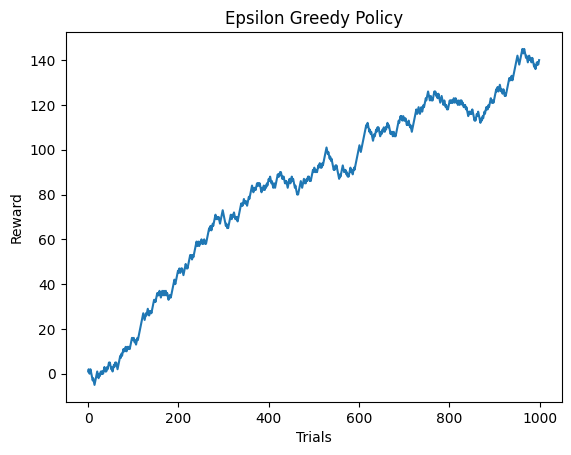

In [ ]:
env = get_bandit_env_7()
# Run the ε-greedy algorithm
env, rewards = run_epsilon_greedy_iterations(env, data_set, treatment_arms, epsilon, iterations,
                              lambda_success, lambda_duration, lambda_budget,
                              alpha_duration, alpha_budget)

# After running, let's print the updated treatment arms data for review
print("\n------------- Composite Rewards Data starts: -------------")
for arm, data in treatment_arms.items():
    print(f"{arm}: Trials={data['trials']}, Successes={data['successes']}, Total Cost={data['total_cost']}, Composite Reward={data['composite_reward']:.4f}")
print("------------- Composite Rewards Data ends: -------------\n")

env.render()
cum_rewards = np.cumsum(rewards)
plt.plot(cum_rewards)
plt.title('Epsilon Greedy Policy')
plt.xlabel('Trials')
plt.ylabel('Reward')
plt.show()